##Sentiment Analysis Using DistilBert
### Accuracy Score on test data: 93.06%



In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'imdb-dataset-of-50k-movie-reviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F134715%2F320111%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240331%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240331T104157Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D302fb468272888e8e3ee067bd1330bf97c5c3899c263890d7856e6bf5ae64c85b3fa0f0b33304b345350c349eaa80013b7678af15010a913fdc2cddfaa521d1db277f942b8e15c693e1b670a108989082113a885c5b35dc99b97a028ef3ef2e706444a47cdd2d4a234a73f7d5ea38542b34a1f746cef0f06aee8ab598494f4f76ff8065dea28bf06416d79eafec0918b24c611a191120feb2d0e939f7521421eaa43f905f6ad667db721b29c7aaa3e8d11342f65605c8ea580474bc9dabee3b9fe03888260fed2c02334ca27e5bf25ef26cd18612a30a4f477646cc3cb74e5ffff1c7f7845607beb751c4ad003ef42eb33ab67db039b4721a1037336439c1299'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 26962657 bytes downloaded
Downloaded and uncompressed: imdb-dataset-of-50k-movie-reviews
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv(r"/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

In [ ]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
df.groupby('sentiment').count()

,review
sentiment,
negative,25000
positive,25000


In [ ]:
df['review'][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [ ]:
import re

def preprocess(text):
    text = text.lower()
    text = re.sub('<.*?>', '', text)
    text = re.sub('\[[^]]*\]', '', text)
    text = re.sub(r'http\S+', '', text)

    return text

In [ ]:
preprocess(df['review'][2])

'i thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. the plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). while some may be disappointed when they realize this is not match point 2: risk addiction, i thought it was proof that woody allen is still fully in control of the style many of us have grown to love.this was the most i\'d laughed at one of woody\'s comedies in years (dare i say a decade?). while i\'ve never been impressed with scarlet johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.this may not be the crown jewel of his career, but it was wittier than "devil wears prada" and more interesting than "superman" a great comedy to go see with friends.'

In [ ]:
df['review'] = df['review'].apply(preprocess)

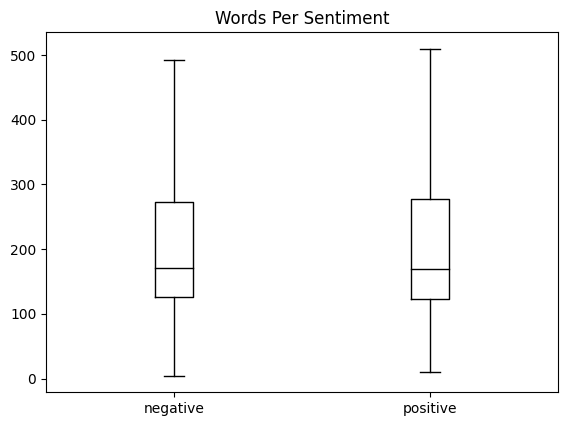

In [ ]:
df["Words Per Sentiment"] = df["review"].str.split().apply(len)
df.boxplot("Words Per Sentiment", by="sentiment", grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [ ]:
df.drop(columns = "Words Per Sentiment", inplace = True)

In [ ]:
df['sentiment'] = df['sentiment'].apply(lambda s: 1 if s == 'positive' else 0)

In [ ]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
text = df['review'][2]
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2245, 2023, 2001, 1037, 6919, 2126, 2000, 5247, 2051, 2006, 1037, 2205, 2980, 2621, 5353, 1010, 3564, 1999, 1996, 2250, 22442, 4258, 1998, 3666, 1037, 2422, 1011, 18627, 4038, 1012, 1996, 5436, 2003, 21934, 24759, 6553, 1010, 2021, 1996, 7982, 2003, 25591, 1998, 1996, 3494, 2024, 5622, 2912, 3468, 1006, 2130, 1996, 2092, 7852, 6878, 7642, 6359, 1007, 1012, 2096, 2070, 2089, 2022, 9364, 2043, 2027, 5382, 2023, 2003, 2025, 2674, 2391, 1016, 1024, 3891, 13449, 1010, 1045, 2245, 2009, 2001, 6947, 2008, 13703, 5297, 2003, 2145, 3929, 1999, 2491, 1997, 1996, 2806, 2116, 1997, 2149, 2031, 4961, 2000, 2293, 1012, 2023, 2001, 1996, 2087, 1045, 1005, 1040, 4191, 2012, 2028, 1997, 13703, 1005, 1055, 22092, 1999, 2086, 1006, 8108, 1045, 2360, 1037, 5476, 1029, 1007, 1012, 2096, 1045, 1005, 2310, 2196, 2042, 7622, 2007, 11862, 13093, 3385, 1010, 1999, 2023, 2016, 3266, 2000, 4309, 2091, 2014, 1000, 7916, 1000, 3746, 1998, 5598, 2157, 2046, 1037, 2779, 1010, 2021, 24462, 24

In [ ]:
tokenizer.vocab_size

30522

In [ ]:
from sklearn.model_selection import train_test_split
X = df['review']
y = df['sentiment']
#train,valid,test = 64%,16%,20%
X_train, X_test, y_train , y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2)

In [ ]:
def tokenize(data):
    return tokenizer(data.tolist(), return_tensors="tf", add_special_tokens = True,
                            max_length = 512,
                            padding= True,
                            truncation=True)

In [ ]:
X_train = tokenize(X_train.values)
X_valid = tokenize(X_valid.values)
X_test = tokenize(X_test.values)

In [ ]:
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
from transformers import AdamWeightDecay
optimizer = AdamWeightDecay(learning_rate =2e-5)
model.compile(optimizer=optimizer)
model.fit(dict(X_train),y_train,batch_size=16, epochs = 3, validation_data = (dict(X_valid),y_valid))

Epoch 1/3
2000/2000 [==============================] - 2561s 1s/step - loss: 0.2045 - val_loss: 0.1146
Epoch 2/3
2000/2000 [==============================] - 2567s 1s/step - loss: 0.1154 - val_loss: 0.0519
Epoch 3/3
2000/2000 [==============================] - 2543s 1s/step - loss: 0.0629 - val_loss: 0.0273


In [ ]:
predictions = model.predict(X_test)

313/313 [==============================] - 215s 675ms/step


In [ ]:
pred_labels = np.argmax(tf.nn.softmax(predictions.logits, axis = -1), axis = 1)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy = accuracy_score(y_test.to_numpy(), pred_labels)
confusion_mat = confusion_matrix(y_test.to_numpy(), pred_labels)
print("Accuracy:",accuracy)

Accuracy: 0.9306


In [ ]:
confusion_mat

array([[4511,  511],
       [ 183, 4795]])

In [ ]:
model.export('/content/gdrive/MyDrive/sentiment analysis/imdb_fine_tune.h5')

Saved artifact at '/content/gdrive/MyDrive/sentiment analysis/imdb_fine_tune.h5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): Dict[['input_ids', TensorSpec(shape=(None, None), dtype=tf.int32, name='input_ids')], ['attention_mask', TensorSpec(shape=(None, None), dtype=tf.int32, name='attention_mask')]]
Output Type:
  Dict[['logits', TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)]]
Captures:
  139960868834464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139960886994624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139960868836224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139960868832352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139960886934192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139960868837984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139960868838864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139960868839392: TensorSpec(shape=(), dtype=tf.resource, name=

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive
